In [1]:
import pandas as pd
import glob

In [ ]:
dfs = [pd.read_json(file) for file in glob.glob("../crawl_data/data/clean/dichvu_qa.json")]
df = pd.concat(dfs, ignore_index=True)
df

,category,intent,question,answer,source_url
0,boc_su_tham_my,dinh_nghia,Bọc răng sứ là gì?,"Bọc răng sứ giải pháp thẩm mỹ răng hàng đầu, p...",https://myauris.vn/dich-vu/boc-su-tham-my
1,boc_su_tham_my,dieu_kien_ap_dung,Trường hợp nên bọc răng sứ?,Công nghệ nha khoa hiện đại đã đưa bọc răng sứ...,https://myauris.vn/dich-vu/boc-su-tham-my
2,boc_su_tham_my,loi_ich,Bọc răng sứ có tốt không?,Bọc răng sứ là một giải pháp phục hình răng hi...,https://myauris.vn/dich-vu/boc-su-tham-my
3,boc_su_tham_my,khac,Các dáng răng sứ được nhiều khách hàng chọn làm,Bọc răng sứ đang là giải pháp thẩm mỹ được nhi...,https://myauris.vn/dich-vu/boc-su-tham-my
4,boc_su_tham_my,quy_trinh,Quy trình bọc răng sứ thẩm mỹ,"Tại Nha khoa My Auris, quy trình bọc răng sứ t...",https://myauris.vn/dich-vu/boc-su-tham-my
...,...,...,...,...,...
74,trong_rang_implant,tac_dung_phu,Trồng răng Implant có đau không?,Cảm giác đau khi cấy Implant phụ thuộc vào cơ ...,https://myauris.vn/dich-vu/trong-rang-implant
75,trong_rang_implant,khac,Phương pháp trồng răng Implant có hạn chế gì k...,Cấy ghép Implant là một kỹ thuật nha khoa phức...,https://myauris.vn/dich-vu/trong-rang-implant
76,trong_rang_implant,dieu_kien_ap_dung,Độ tuổi trồng răng Implant tốt nhất là bao nhiêu?,Tuổi lý tưởng để trồng răng Implant thường bắt...,https://myauris.vn/dich-vu/trong-rang-implant
77,trong_rang_implant,thoi_gian,Trồng răng Implant bao lâu thì lành vết thương?,"Sau khi cấy trụ Implant, khách hàng cần chờ từ...",https://myauris.vn/dich-vu/trong-rang-implant


c:\Users\FPTSHOP\.conda\envs\dev\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


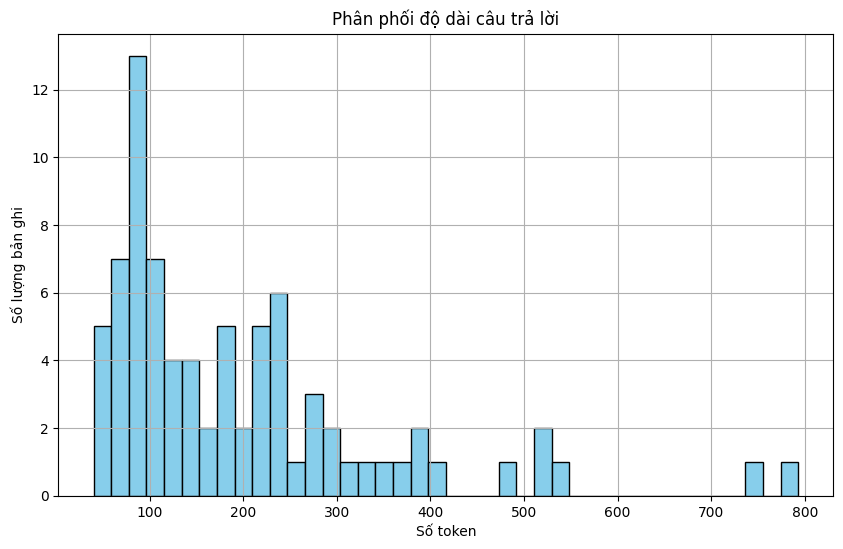

In [3]:
from transformers import AutoTokenizer
import matplotlib.pyplot as plt

tokenizer = AutoTokenizer.from_pretrained("vinai/PhoGPT-4B-Chat")
df["answer_token_length"] = df["answer"].apply(lambda x: len(tokenizer.encode(str(x), truncation=False)))

plt.figure(figsize=(10,6))
plt.hist(df["answer_token_length"], bins=40, color="skyblue", edgecolor="black")
plt.title("Phân phối độ dài câu trả lời")
plt.xlabel("Số token")
plt.ylabel("Số lượng bản ghi")
plt.grid(True)
plt.show()


In [4]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("vinai/PhoGPT-4B-Chat")

text_splitter = RecursiveCharacterTextSplitter.from_huggingface_tokenizer(
    tokenizer,
    chunk_size=512,
    chunk_overlap=96,
    strip_whitespace=True,
    add_start_index=True
)


In [5]:
from langchain.schema import Document

docs = []

for i, row in df.iterrows():
    combined_text = f"Q: {row['question']}\nA: {row['answer']}"
    chunks = text_splitter.split_text(combined_text)
    
    for idx, chunk in enumerate(chunks):
        docs.append(Document(
            page_content=chunk,
            metadata={
                "category": row["category"],
                "intent": row["intent"],
                "question": row["question"],
                "source_url": row["source_url"],
                "chunk_id": idx
            }
        ))


In [6]:
import json

with open("../data/clean/myauris_allqa.jsonl", "w", encoding="utf-8") as f:
    for doc in docs:
        f.write(json.dumps({
            "text": doc.page_content,
            "metadata": doc.metadata
        }, ensure_ascii=False) + "\n")
